In [1]:
import sys
import os

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from ipywidgets import interactive, IntSlider

import numpy as np
import pandas as pd
import sqlite3
import torch

In [4]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

In [9]:
sys.path.append('../..')

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [10]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [12]:
connection = sqlite3.connect("../../exp090924_100trials.db")
cursor = connection.cursor()

In [13]:
env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")

In [14]:
run_table

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
idx,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,8.446059,22,12.0,29.0,27.0,5.0,4.0,...,16.0,9.0,4.0,19.0,2.0,16.0,20.0,27.0,2.0,41.291305
2,1,0,1,9.366124,29,23.0,10.0,22.0,2.0,6.0,...,8.0,17.0,12.0,29.0,3.0,5.0,12.0,24.0,15.0,38.557146
3,1,0,2,7.121163,28,29.0,25.0,12.0,22.0,18.0,...,7.0,11.0,20.0,4.0,2.0,7.0,19.0,2.0,12.0,40.417113
4,1,0,3,2.661072,2,25.0,12.0,6.0,11.0,23.0,...,7.0,24.0,9.0,27.0,7.0,3.0,6.0,4.0,17.0,75.683719
5,1,0,4,6.078120,30,9.0,11.0,21.0,19.0,22.0,...,24.0,25.0,27.0,29.0,3.0,18.0,22.0,15.0,18.0,32.554515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,15,99,95,1.329191,17,2.0,2.0,2.0,15.0,2.0,...,2.0,25.0,5.0,5.0,8.0,3.0,29.0,24.0,18.0,36.857994
149997,15,99,96,1.895400,20,2.0,4.0,2.0,24.0,1.0,...,2.0,15.0,5.0,7.0,1.0,5.0,19.0,13.0,18.0,37.238500
149998,15,99,97,1.329191,14,2.0,8.0,2.0,14.0,9.0,...,2.0,24.0,7.0,5.0,8.0,2.0,23.0,26.0,18.0,38.462807


In [15]:
WL_COLUMNS = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
SYS_COLUMNS = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']

In [16]:
env_table.head(10)

,empty_reads,non_empty_reads,range_queries,writes,entry_size,selectivity,entries_per_page,num_elmement,bits_per_elem_max,read_write_asym
env_id,,,,,,,,,,
1,0.25,0.25,0.25,0.25,8192,4.000000e-07,4,1000000000,10.0,1.0
2,0.97,0.01,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
3,0.01,0.97,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
4,0.01,0.01,0.97,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
5,0.01,0.01,0.01,0.97,8192,4.000000e-07,4,1000000000,10.0,1.0
6,0.49,0.49,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
7,0.49,0.01,0.49,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
8,0.49,0.01,0.01,0.49,8192,4.000000e-07,4,1000000000,10.0,1.0
9,0.01,0.49,0.49,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0


In [17]:
run_table.head(10)

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
idx,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,8.446059,22,12.0,29.0,27.0,5.0,4.0,...,16.0,9.0,4.0,19.0,2.0,16.0,20.0,27.0,2.0,41.291305
2,1,0,1,9.366124,29,23.0,10.0,22.0,2.0,6.0,...,8.0,17.0,12.0,29.0,3.0,5.0,12.0,24.0,15.0,38.557146
3,1,0,2,7.121163,28,29.0,25.0,12.0,22.0,18.0,...,7.0,11.0,20.0,4.0,2.0,7.0,19.0,2.0,12.0,40.417113
4,1,0,3,2.661072,2,25.0,12.0,6.0,11.0,23.0,...,7.0,24.0,9.0,27.0,7.0,3.0,6.0,4.0,17.0,75.683719
5,1,0,4,6.078120,30,9.0,11.0,21.0,19.0,22.0,...,24.0,25.0,27.0,29.0,3.0,18.0,22.0,15.0,18.0,32.554515
6,1,0,5,7.854671,30,9.0,7.0,15.0,23.0,25.0,...,4.0,27.0,2.0,13.0,13.0,17.0,21.0,26.0,8.0,31.650590
7,1,0,6,6.078120,30,9.0,7.0,21.0,23.0,25.0,...,20.0,25.0,27.0,29.0,4.0,18.0,22.0,19.0,18.0,31.644664
8,1,0,7,9.642130,30,5.0,3.0,20.0,3.0,10.0,...,5.0,16.0,2.0,22.0,29.0,23.0,2.0,17.0,18.0,33.325118
9,1,0,8,8.820462,8,5.0,9.0,18.0,29.0,29.0,...,4.0,18.0,22.0,3.0,18.0,24.0,7.0,20.0,2.0,43.023940


In [18]:
run_table.query("env_id == 5")

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
idx,,,,,,,,,,,,,,,,,,,,,
40001,5,0,0,9.617086,27,25.0,1.0,5.0,7.0,28.0,...,2.0,9.0,27.0,27.0,4.0,6.0,8.0,9.0,16.0,9.897545
40002,5,0,1,9.621794,24,9.0,17.0,22.0,14.0,19.0,...,24.0,14.0,29.0,5.0,20.0,10.0,19.0,6.0,10.0,3.531680
40003,5,0,2,5.603750,5,25.0,14.0,25.0,4.0,6.0,...,22.0,18.0,13.0,4.0,20.0,5.0,6.0,23.0,12.0,3.376512
40004,5,0,3,1.274789,7,2.0,21.0,7.0,8.0,7.0,...,22.0,29.0,20.0,12.0,13.0,25.0,26.0,21.0,22.0,3.406686
40005,5,0,4,4.146000,9,6.0,9.0,25.0,19.0,3.0,...,6.0,29.0,21.0,11.0,19.0,11.0,16.0,24.0,20.0,2.971394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,5,99,95,3.809589,19,24.0,21.0,16.0,24.0,11.0,...,13.0,7.0,7.0,16.0,1.0,17.0,5.0,24.0,9.0,2.680846
49997,5,99,96,3.809589,20,20.0,21.0,17.0,20.0,9.0,...,8.0,3.0,13.0,18.0,2.0,17.0,5.0,26.0,8.0,2.678207
49998,5,99,97,3.784621,27,20.0,25.0,16.0,20.0,9.0,...,20.0,5.0,5.0,20.0,2.0,20.0,5.0,26.0,8.0,2.702026


In [19]:
run_table.describe()

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,8.000000,49.500000,49.500000,5.421075,19.632773,8.713020,8.435000,7.811907,13.516727,15.081647,...,15.072387,15.013313,15.127633,15.232773,14.850227,14.781687,14.933687,15.008660,15.096947,30.677449
std,4.320508,28.866166,28.866166,2.544237,7.403458,8.108271,8.015864,7.469725,8.644905,8.421678,...,8.352975,8.367565,8.297796,8.386762,8.373828,8.342765,8.384508,8.377347,8.305341,32.692459
min,1.000000,0.000000,0.000000,1.000003,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.158460
25%,4.000000,24.750000,24.750000,3.228518,14.000000,2.000000,2.000000,1.000000,6.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2.505460
50%,8.000000,49.500000,49.500000,5.589569,20.000000,5.000000,5.000000,5.000000,13.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,29.432591
75%,12.000000,74.250000,74.250000,7.607459,26.000000,14.000000,14.000000,12.000000,21.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,50.792170
max,15.000000,99.000000,99.000000,9.899992,30.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,361.543060


# Load in LTune Model

In [20]:
path = '/scratchNVMe/ndhuynh/other_data/models/ltune/klsm_100824_1324/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
cf = EndureCost(config)
design_type = getattr(Policy, config["lsm"]["design"])
bounds = LSMBounds(**config["lsm"]["bounds"])

In [23]:
model = LTuneModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["ltune"]["model"],
).build_model(design_type)
model_name = os.path.join(path, 'best.model')
model_name = os.path.join(path, 'checkpoints/epoch_03.checkpoint')
model_data = torch.load(model_name, weights_only=True)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [24]:
ltune_util = LTuneEvalUtil(config, model, design_type)

## Example of how to evaluate ltune

In [25]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)

# Plotting Experiments


1. Train a LTune model
2. Start with a clean BO model
3. Pick a workload, w, that both models have not seen
4. Train BO model, while capturing the designs at each round (round <- (suggest, cost, register))
5. Plot performance of each round, and the performance of a single LTune suggestion for w

## Parameters

Change run_id to look at a different environment setup

In [26]:
def add_learned_tunings(con: sqlite3.Connection) -> None:
    cursor = con.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS learned_tunings (
            env_id INTEGER PRIMARY KEY AUTOINCREMENT,
            bits_per_elem REAL,
            size_ratio INTEGER,
            kap0 REAL, kap1 REAL, kap2 REAL, kap3 REAL, kap4 REAL,
            kap5 REAL, kap6 REAL, kap7 REAL, kap8 REAL, kap9 REAL,
            kap10 REAL, kap11 REAL, kap12 REAL, kap13 REAL, kap14 REAL,
            kap15 REAL, kap16 REAL, kap17 REAL, kap18 REAL, kap19 REAL,
            cost REAL,
            FOREIGN KEY (env_id) REFERENCES workloads(env_id)
        );
        """
    )
    environment_ids = cursor.execute("SELECT env_id FROM environments").fetchall()
    for (env_id,) in environment_ids:
        env = env_table.query(f'env_id == {env_id}')
        data = run_table.query(f'env_id == {env_id}')
        wl = Workload(*env[WL_COLUMNS].values[0])
        system = System(*env[SYS_COLUMNS].values[0])
        with torch.no_grad():
            out = ltune_util.get_ltune_out(system, wl.z0, wl.z1, wl.q, wl.w, hard=True)
        ltune_design = ltune_util.convert_ltune_output(out)
        ltune_cost = cf.calc_cost(ltune_design, system, wl.z0, wl.z1, wl.q, wl.w)
        cursor.execute(
            """
            INSERT OR REPLACE INTO learned_tunings (
            env_id,
            bits_per_elem,
            size_ratio,
            kap0, kap1, kap2, kap3, kap4,
            kap5, kap6, kap7, kap8, kap9,
            kap10, kap11, kap12, kap13, kap14,
            kap15, kap16, kap17, kap18, kap19,
            cost
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,? ,? ,? ,?, ?, ?)
            """,
            (env_id, ltune_design.h, int(ltune_design.T)) + tuple(ltune_design.K) + (ltune_cost,)
        )
    cursor.close()
    con.commit()
    
    ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", con, index_col="env_id")
    return ltune_table

In [27]:
# ltune_table = add_learned_tunings(connection)
ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", connection, index_col="env_id")
ltune_table

,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,kap5,kap6,kap7,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
env_id,,,,,,,,,,,,,,,,,,,,,
1,0.474392,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.129191
2,6.268737,10,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.255190
3,6.004708,17,6.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.227736
4,-0.041190,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,99.082433
5,1.329451,10,6.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.525593
6,5.394937,10,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.728118
7,-0.024007,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.700491
8,3.672716,10,6.0,3.0,4.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.678352
9,-0.032469,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.633893


In [28]:
def get_data(env_id):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values[0]
    
    group = run_table.query(f'env_id == {env_id}').groupby("round")['cost'].agg(['mean', 'std', 'count'])
    group = group.reset_index()
    group['ci'] = 1.96 * group['std'] / np.sqrt(group['count'])
    group['ci_lower'] = group['mean'] - group['ci']
    group['ci_upper'] = group['mean'] + group['ci']
    group['ltune_cost'] = ltune_cost

    return group, wl, ltune_cost

In [29]:
def plot_env(env_id: int = 1):
    group, wl, ltune_cost = get_data(env_id)
    
    fig, ax = plt.subplots()
    ax.plot(group['round'], group['mean'], label='Bayesian Optimizer', color='tab:gray', marker='o')
    ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
    ax.hlines(y=ltune_cost, xmin=0, xmax=group['round'].values.max(), label='LTune', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, wl, system, fig, ax

In [30]:
def plot_cumulative_env(env_id: int = 1):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values
    
    x, y = data['round'].values, data['cost'].values
    aggregated_cost = []
    tmp = []
    for i in range(1, len(data['cost'].values)):
        aggregated_cost.append(sum(data['cost'].values[:i]))
    aggregated_cost.append(data['cost'].values[i]+aggregated_cost[i-1])

    ltune_aggregated_cost = ltune_cost * np.arange(1, len(x) + 1)
    fig, ax = plt.subplots()
    ax.plot(x, aggregated_cost, label='Bayesian Optimizer (Aggregated)', color='tab:gray')
    ax.plot(x, ltune_aggregated_cost, label='LTune (Aggregated)', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Aggregated Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, ltune_design, wl, system, fig, ax

In [31]:
id_widget = IntSlider(min=1, max=len(env_table), step=1)
iplot_env = interactive(plot_env, env_id=id_widget)
iplot_env

interactive(children=(IntSlider(value=1, description='env_id', max=15, min=1), Output()), _dom_classes=('widge…

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:26: SyntaxWarning: invalid escape sequence '\%'
<>:26: SyntaxWarning: invalid escape sequence '\%'
<>:26: SyntaxWarning: invalid escape sequence '\%'
<>:26: SyntaxWarning: invalid escape sequence '\%'
<>:31: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:41: SyntaxWarning: invalid escape sequence '\%'
<>:49: SyntaxWarning: invalid escape sequence '\%'
<>:49: SyntaxWarning: invalid escape sequence '\%'
<>:49: SyntaxWarning: invalid escape sequence '\%'
<>:49: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid e

Text(0.02, 0.5, '$C_S(w, \\varphi)$')

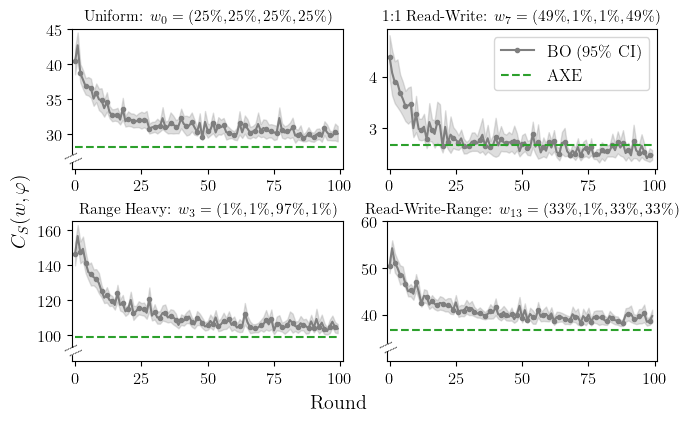

In [32]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(2*width, 2*height), constrained_layout=True)

data, wl, ltune_cost = get_data(1)
ax = axes[0, 0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'].values[0], xmin=0, xmax=data['round'].values.max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([25, 45])
ax.set_yticks([30, 35, 40, 45])
ax.text(-4.5, 25.6, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 26.5, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
# ax.set_title(f'Uniform: $w_0$', fontsize=12)

data, wl, ltune_cost = get_data(4)
ax = axes[1, 0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'].values[0], xmin=0, xmax=data['round'].values.max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([85, 165])
ax.text(-4.5, 87.8, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 91, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Range Heavy: $w_3 = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
# ax.set_title(f'Range Heavy: $w_3$', fontsize=12)

data, wl, ltune_cost = get_data(8)
ax = axes[0, 1]
ax.plot(data['round'], data['mean'], label='BO (95\% CI)', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'].values[0], xmin=0, xmax=data['round'].values.max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_title(f'1:1 Read-Write: $w_7 = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
ax.legend(loc='upper right') # , bbox_to_anchor=(1.02, 1.05))
# ax.set_title(f'1:1 Read-Write: $w_7$', fontsize=12)

data, wl, ltune_cost = get_data(14)
ax = axes[1, 1]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer (95\% CI)', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'].values[0], xmin=0, xmax=data['round'].values.max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([30, 60])
ax.set_yticks([40, 50, 60])
ax.text(-4.5, 31.8, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 33, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Read-Write-Range: $w_{{13}} = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
# ax.set_title(f'Read-Write-Range: $w_{{13}}$', fontsize=12)

fig.supxlabel('Round')
fig.supylabel(r'$C_S(w, \varphi)$')
# save_fig(fig, 'bo_comparison_with_init.pdf')
# save_fig(fig, 'bo_comparison.pdf')

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_3007285/1424013425.py:14: SyntaxWarning: invalid escape sequence '\%'
  ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100

Text(0.02, 0.5, '$C_S(w, \\varphi)$')

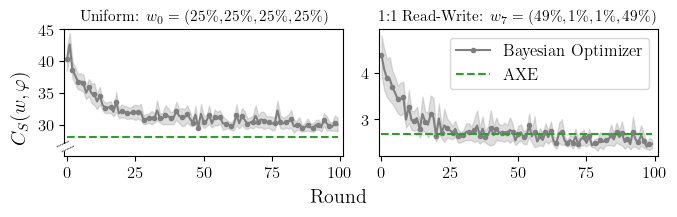

In [33]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*width, 1*height), constrained_layout=True)

data, wl, ltune_cost = get_data(1)
ax = axes[0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'].values[0], xmin=0, xmax=data['round'].values.max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_ylim([25, 45])
ax.set_yticks([30, 35, 40, 45])
ax.text(-4.5, 25.6, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 26.5, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
# ax.set_title(f'Uniform: $w_0$', fontsize=12)

data, wl, ltune_cost = get_data(8)
ax = axes[1]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltune_cost'].values[0], xmin=0, xmax=data['round'].values.max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_title(f'1:1 Read-Write: $w_7 = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
ax.legend(loc='upper right') # , bbox_to_anchor=(1.02, 1.05))
# ax.set_title(f'1:1 Read-Write: $w_7$', fontsize=12)

fig.supxlabel('Round')
fig.supylabel(r'$C_S(w, \varphi)$')
# save_fig(fig, 'bo_comparison_with_init.pdf')

# Analyzing Trends

1. The first graph is a simple cutoff, we count the rounds up until Bayesian Optimization provides a configuration that is lower in expected cost than the design provided by LTune.

2. TODO: Come up with window criteria

In [34]:
# sql_query = """
#     SELECT
#         t.env_id,
#         t.trial,
#         MIN(t.round) as min_round
#     FROM tunings t
#     INNER JOIN learned_tunings lt ON t.env_id = lt.env_id
#     WHERE t.cost < lt.cost
#     GROUP BY t.env_id, t.trial;
#     """
# df = pd.read_sql(sql_query, connection)
# potential_total = pd.read_sql("SELECT COUNT(*) FROM (SELECT DISTINCT env_id, trial FROM tunings)", connection).values[0][0]
# data = df['min_round'].values
# data = np.concatenate([data, [float('inf') for _ in range(potential_total - len(data))]])

# fig, ax = plt.subplots()
# ax.ecdf(data, label="CDF", complementary=False)
# ax.set_xlabel("BO Rounds")
# ax.set_ylabel("Probability of Occurence")
# ax.set_title("Rounds Once BO Outperforms LTune")
# ax.grid()
# plt.show()

In [35]:
def plot_windowing_cdf(window_size=1):
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    fig, ax = plt.subplots()
    ax.ecdf(data, label="CDF", complementary=False)
    ax.set_xlabel("Round $i$")
    ax.set_ylabel(f"$P[\omega_{{{window_size},i}}]$", size=12)
    ax.grid()
    plt.show()

    return fig, ax, data

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3007285/1035125754.py:11: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel(f"$P[\omega_{{{window_size},i}}]$", size=12)


In [36]:
# window_size_widget = IntSlider(min=1, max=10, step=1)
# iplot_cdf = interactive(plot_windowing_cdf, window_size=window_size_widget)
# iplot_cdf

In [37]:
def get_window_data(window_range=range(1,5)):
    data = []
    for window_size in window_range:
        row = []
        for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
            valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                             .rolling(window_size).min().fillna(0) \
                             .to_numpy().nonzero()[0]
            row.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
        data.append(row)

    return data

data = get_window_data(range(1, 5))

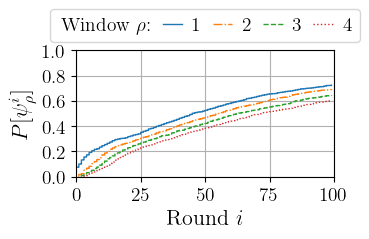

In [38]:
plt.rcParams.update({'font.size': 14})
    
fig, ax = plt.subplots(figsize=(1*width, 0.8*height))
linestyles = ('solid', '-.', 'dashed', 'dotted')
ax.plot(np.NaN, np.NaN, '', color='none', label=r'Window $\rho$:')
for window in range(1, 5):
    ax.ecdf(data[window - 1], label=window, complementary=False, rasterized=True, linewidth=1, linestyle=linestyles[window - 1])

ax.set_xlabel("Round $i$", fontsize=16)
ax.set_ylabel(r"$P[ \psi_\rho^i ]$", fontsize=16)
ax.set_xlim([0, 100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0, 1])
# ax.legend(title=r"Window $\rho$", fontsize=11, loc='upper left', bbox_to_anchor=(-0.02,1.03), labelspacing=0.1)
leg = ax.legend(loc='upper center', ncols=5, bbox_to_anchor=(0.5,1.40), handletextpad=0.5, handlelength=1, labelspacing=0.1, columnspacing=0.6)

for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(-5)

ax.grid()
plt.show()
# save_fig(fig, 'bo_window_cdf.pdf')

In [39]:
run_table['cum_sum'] = run_table.groupby(['env_id', 'trial'])['cost'].cumsum()
df = run_table.join(ltune_table.cost, on='env_id', rsuffix='_axe')
df = df.join(env_table.writes, on='env_id')
df['delta_regret'] = df['cum_sum'] - df['cost_axe']
df['norm_delta_cost'] = (df['cost'] - df['cost_axe']) / df['cost_axe']

wl_categories = (
    {1: 0}
    | {i: 1 for i in range(2, 6)}
    | {i: 2 for i in range(6, 12)}
    | {i: 3 for i in range(12, 16)}
)
df['wl_type'] = df['env_id'].replace(wl_categories)

min_table = df.loc[df.groupby(['env_id', 'trial']).norm_delta_cost.idxmin()]

In [40]:
df

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap17,kap18,kap19,cost,cum_sum,cost_axe,writes,delta_regret,norm_delta_cost,wl_type
idx,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,8.446059,22,12.0,29.0,27.0,5.0,4.0,...,20.0,27.0,2.0,41.291305,41.291305,28.129191,0.25,13.162114,0.467917,0
2,1,0,1,9.366124,29,23.0,10.0,22.0,2.0,6.0,...,12.0,24.0,15.0,38.557146,79.848451,28.129191,0.25,51.719260,0.370716,0
3,1,0,2,7.121163,28,29.0,25.0,12.0,22.0,18.0,...,19.0,2.0,12.0,40.417113,120.265564,28.129191,0.25,92.136373,0.436839,0
4,1,0,3,2.661072,2,25.0,12.0,6.0,11.0,23.0,...,6.0,4.0,17.0,75.683719,195.949284,28.129191,0.25,167.820092,1.690576,0
5,1,0,4,6.078120,30,9.0,11.0,21.0,19.0,22.0,...,22.0,15.0,18.0,32.554515,228.503799,28.129191,0.25,200.374608,0.157321,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,15,99,95,1.329191,17,2.0,2.0,2.0,15.0,2.0,...,29.0,24.0,18.0,36.857994,3881.422125,36.754095,0.33,3844.668030,0.002827,3
149997,15,99,96,1.895400,20,2.0,4.0,2.0,24.0,1.0,...,19.0,13.0,18.0,37.238500,3918.660625,36.754095,0.33,3881.906530,0.013180,3
149998,15,99,97,1.329191,14,2.0,8.0,2.0,14.0,9.0,...,23.0,26.0,18.0,38.462807,3957.123432,36.754095,0.33,3920.369337,0.046490,3


In [41]:
# fig, ax = plt.subplots(figsize=(1*width, 1*height))
# env_id = 8

# env = env_table.query(f'env_id == {env_id}')
# data = run_table.query(f'env_id == {env_id}')
# learned_tuning = ltune_table.query(f'env_id == {env_id}')
# wl = Workload(*env[WL_COLUMNS].values[0])

# y = df[df['env_id'] == env_id]['delta_regret'].values / df[df['env_id'] == env_id]['cost_axe']
# x = df[df['env_id'] == env_id]['round'].values

# ax.scatter(x, y, marker='.', s=1)
# ax.set_ylabel(r'$\Delta R_{\ell} / C_{\mathrm{AXE}}$')
# ax.set_xlabel('Round')
# ax.set_title(f'$w_{env_id - 1} = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
# None

In [42]:
# fig, ax = plt.subplots(figsize=(1*width, 1*height))
# env_id = 8

# env = env_table.query(f'env_id == {env_id}')
# data = run_table.query(f'env_id == {env_id}')
# learned_tuning = ltune_table.query(f'env_id == {env_id}')
# wl = Workload(*env[WL_COLUMNS].values[0])

# # x = df[df['env_id'] == env_id]['norm_delta_cost'].values
# # y = df[df['env_id'] == env_id]['delta_regret'].values
# x = df['norm_delta_cost'].values
# y = df['delta_regret'].values

# ax.scatter(x, y, s=1, marker='.')
# ax.set_ylabel(r'$\Delta R_{\ell}$')
# ax.set_xlabel(r'$\Upsilon(w_7, \varphi_{\mathrm{AXE}}, \varphi_{\mathrm{BO}})$')
# # ax.set_title(f'$w_{env_id - 1} = ({wl.z0*100:.0f}\%, {wl.z1*100:.0f}\%, {wl.q*100:.0f}\%, {wl.w*100:.0f}\%)$', fontsize=11)
# ax.xaxis.set_major_formatter(PercentFormatter(1))
# None

In [43]:
# data = []
# window_size = 3
# for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
#     valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
#                      .rolling(window_size).min().fillna(0) \
#                      .to_numpy().nonzero()[0]
#     data.append(100 if len(valid_idx) == 0 else valid_idx[0])
    
# rows = []
# for ((env_id, trial), group), idx in zip(df.groupby(['env_id', 'trial']), data):
#     rows.append(group.iloc[idx - 1])

# opt_table = pd.DataFrame(rows)

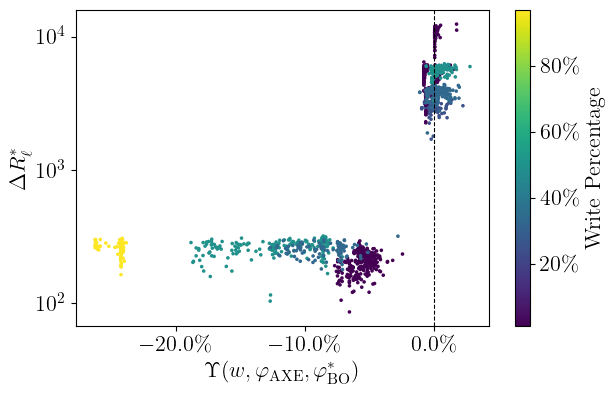

In [44]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(2*width, 2*height))

# settings = (
#     (0, 'Uniform', '.'),
#     (1, 'Unimodal', 'x'),
#     (2, 'Bimodal', '*'),
#     (3, 'Trimodal', 'd')
# )
# for wl_id, name, marker in settings:
#     y = min_table[min_table['wl_type'] == wl_id]['delta_regret'].values
#     x = min_table[min_table['wl_type'] == wl_id]['norm_delta_cost'].values
#     im = ax.scatter(x, y, marker=marker, s=10, label=name, rasterized=True)
y = min_table['delta_regret'].values
x = min_table['norm_delta_cost'].values
sc = ax.scatter(x, y, marker='.', s=10, c=min_table['writes'], rasterized=True)
cbar = plt.colorbar(sc, format=PercentFormatter(1))
cbar.set_label('Write Percentage')
# cbar.set_major_formatter(PercentFormatter(1))
    
ax.set_ylabel(r'$\Delta R_{\ell}^*$')
ax.set_xlabel(r'$\Upsilon(w, \varphi_{\mathrm{AXE}}, \varphi_{\mathrm{BO}}^*)$')
ax.set_yscale('symlog')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.xaxis.set_major_formatter(PercentFormatter(1))

In [45]:
df.query('cost > cost_axe').shape[0] / df.shape[0]

0.6496533333333333

In [46]:
list(df.query(f'wl_type == {wl_type} and cost > cost_axe').shape[0] / df.query(f'wl_type == {wl_type}').shape[0] for wl_type in range(4))

[0.9147, 0.536325, 0.6202666666666666, 0.7408]

In [47]:
min_table.query('cost < cost_axe').shape[0] / min_table.shape[0]

0.7233333333333334

In [48]:
min_table['alpha'] = min_table['delta_regret'] / min_table['cost_axe']
min_table.groupby(['wl_type'])[['delta_regret', 'norm_delta_cost', 'alpha', 'cost_axe']].mean()

,delta_regret,norm_delta_cost,alpha,cost_axe
wl_type,,,,
0,2894.297042,-0.001079,102.893005,28.129191
1,2790.187328,-0.090940,105.860682,26.522738
2,2828.695116,-0.048836,102.643767,27.126487
3,2854.819224,-0.022301,102.028822,27.649322
